In [ ]:
!pip install catboost
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from nltk.tokenize import word_tokenize
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
import nltk
import optuna
from sklearn.model_selection import train_test_split
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# test = pd.read_csv('test.csv')
# train = pd.read_csv('train.csv')

In [ ]:
data = pd.read_json('News_Category_Dataset_v3.json', lines=True)
data.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [ ]:
data = data.drop(columns=['authors','link','date'])
data.head()

,headline,category,short_description
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha..."
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to..."
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...


In [ ]:
data['content'] = data.headline + ' ' + data.short_description
labels = data.category
data.head()

,headline,category,short_description,content
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,Over 4 Million Americans Roll Up Sleeves For O...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,"American Airlines Flyer Charged, Banned For Li..."
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",23 Of The Funniest Tweets About Cats And Dogs ...
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",The Funniest Tweets From Parents This Week (Se...
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Woman Who Called Cops On Black Bird-Watcher Lo...


In [ ]:
text = pd.DataFrame(data.content)
labels = data.category

In [ ]:
train, test, train_labels, test_labels = train_test_split(text, labels,
random_state=42,test_size=0.20, stratify=labels)

In [ ]:
def normalise_text(text):
    text = text.lower()  # lowercase
    text = text.replace(r"\#", "")  # replaces hashtags
    text = text.replace(r"http\S+", "URL")  # remove URL addresses
    text = text.replace(r"@", "")
    text = text.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.replace("\s{2,}", " ")
    return text

In [ ]:
def datacleaning(text):
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]","", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", " ", text)
    text = text.lower()
    
    # removing stop-words
    text = [word for word in text.split() if word not in list(STOPWORDS)]
    # text = [word for word in text.split()]
    
    # word lemmatization
    sentence = []
    snow_stemmer = SnowballStemmer(language='english')
    for word in text:
        # lemmatizer = WordNetLemmatizer()
        sentence.append(snow_stemmer.stem(word))
        # sentence.append(lemmatizer.lemmatize(word,'v'))
        # sentence.append(lemmatizer.lemmatize(word))
        
    return ' '.join(text) 

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# train.content = train.content.apply(normalise_text)
# test.content = test.content.apply(normalise_text)
train.content = train.content.apply(datacleaning)
test.content = test.content.apply(datacleaning)

In [ ]:
bow_counts = CountVectorizer(tokenizer= word_tokenize, # type of tokenization
                             ngram_range=(1,2)) # number of n-grams

bow_train = bow_counts.fit_transform(train['content'])
bow_test = bow_counts.transform(test['content'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(max_iter=10000),
    MultinomialNB(),
    # LogisticRegression(random_state=0, max_iter=10000)
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    print(model_name)
    accuracies = cross_val_score(model, bow_train, train_labels, scoring='accuracy', cv=CV, verbose=3, n_jobs=3)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

RandomForestClassifier


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed:  3.5min remaining:  5.3min
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  5.9min finished


LinearSVC


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed: 29.1min remaining: 43.6min
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed: 46.3min finished


MultinomialNB


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed:   20.2s remaining:   30.2s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:   37.1s finished


In [ ]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1,
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.609094,0.002822
MultinomialNB,0.402849,0.001343
RandomForestClassifier,0.170349,0.000971


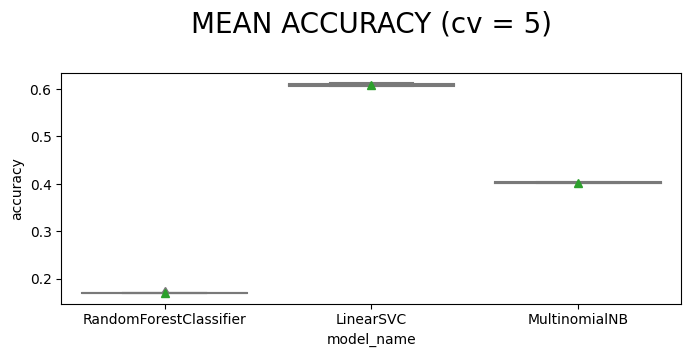

In [ ]:
plt.figure(figsize=(8,3))
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            color='lightblue',
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=20);

1. Text normalise

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train, train_labels, test_size=0.2, random_state=42)

In [ ]:
bow_counts = CountVectorizer(tokenizer= word_tokenize, # type of tokenization
                             ngram_range=(1,2)) # number of n-grams

bow_train = bow_counts.fit_transform(X_train['content'])
bow_valid = bow_counts.transform(X_valid['content'])
bow_test = bow_counts.transform(test['content'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
def objective(trial):
    global bow_train, y_train, bow_valid, y_valid

    c = trial.suggest_float("svc_c", 1e-1, 1e2, log=True)

    clf = LinearSVC(C=c, random_state=3, class_weight='balanced', max_iter=100000)
    clf.fit(bow_train, y_train)

    return metrics.f1_score(clf.predict(bow_valid), y_valid, average='macro')


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)
print(study.best_trial)

[I 2023-06-02 08:43:32,236] A new study created in memory with name: no-name-af820276-7118-45de-85f9-9c1f1a45e1e8
[I 2023-06-02 08:48:29,625] Trial 0 finished with value: 0.48850281937247564 and parameters: {'svc_c': 0.29359416307660574}. Best is trial 0 with value: 0.48850281937247564.
[I 2023-06-02 08:52:41,394] Trial 1 finished with value: 0.49117530999223125 and parameters: {'svc_c': 0.21204810755983647}. Best is trial 1 with value: 0.49117530999223125.
[I 2023-06-02 08:56:11,666] Trial 2 finished with value: 0.4944672808865322 and parameters: {'svc_c': 0.1462549847683648}. Best is trial 2 with value: 0.4944672808865322.


In [ ]:
bow_counts = CountVectorizer(tokenizer= word_tokenize, # type of tokenization
                             ngram_range=(1,2)) # number of n-grams

bow_train = bow_counts.fit_transform(train['content'])
bow_test = bow_counts.transform(test['content'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
clf = LinearSVC(C=0.1, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(bow_train, train_labels)

LinearSVC(C=0.1, class_weight='balanced', max_iter=100000, random_state=42)

In [ ]:
y_pred = clf.predict(bow_test)

In [ ]:
# 0.1 42
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
f1_score_weighted = metrics.f1_score(test_labels, y_pred, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.625519018756264
F1 Score (Micro) = 0.625519018756264
F1 Score (Macro) = 0.5083948534618092
F1 Score (Weighted) = 0.6205248953087515


In [ ]:
# c = 0,1
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS

                precision    recall  f1-score   support

          ARTS       0.35      0.32      0.33       302
ARTS & CULTURE       0.38      0.25      0.31       268
  BLACK VOICES       0.51      0.48      0.49       917
      BUSINESS       0.50      0.49      0.49      1198
       COLLEGE       0.44      0.43      0.44       229
        COMEDY       0.54      0.50      0.52      1080
         CRIME       0.52      0.61      0.56       712
CULTURE & ARTS       0.58      0.29      0.39       215
       DIVORCE       0.79      0.73      0.76       685
     EDUCATION       0.43      0.42      0.43       203
 ENTERTAINMENT       0.69      0.74      0.71      3473
   ENVIRONMENT       0.57      0.34      0.42       289
         FIFTY       0.31      0.24      0.27       280
  FOOD & DRINK       0.65      0.71      0.68      1268
     GOOD NEWS       0.32      0.28      0.30       280
         GREEN       0.37      0.37      0.37       524
HEALTHY LIVING    

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

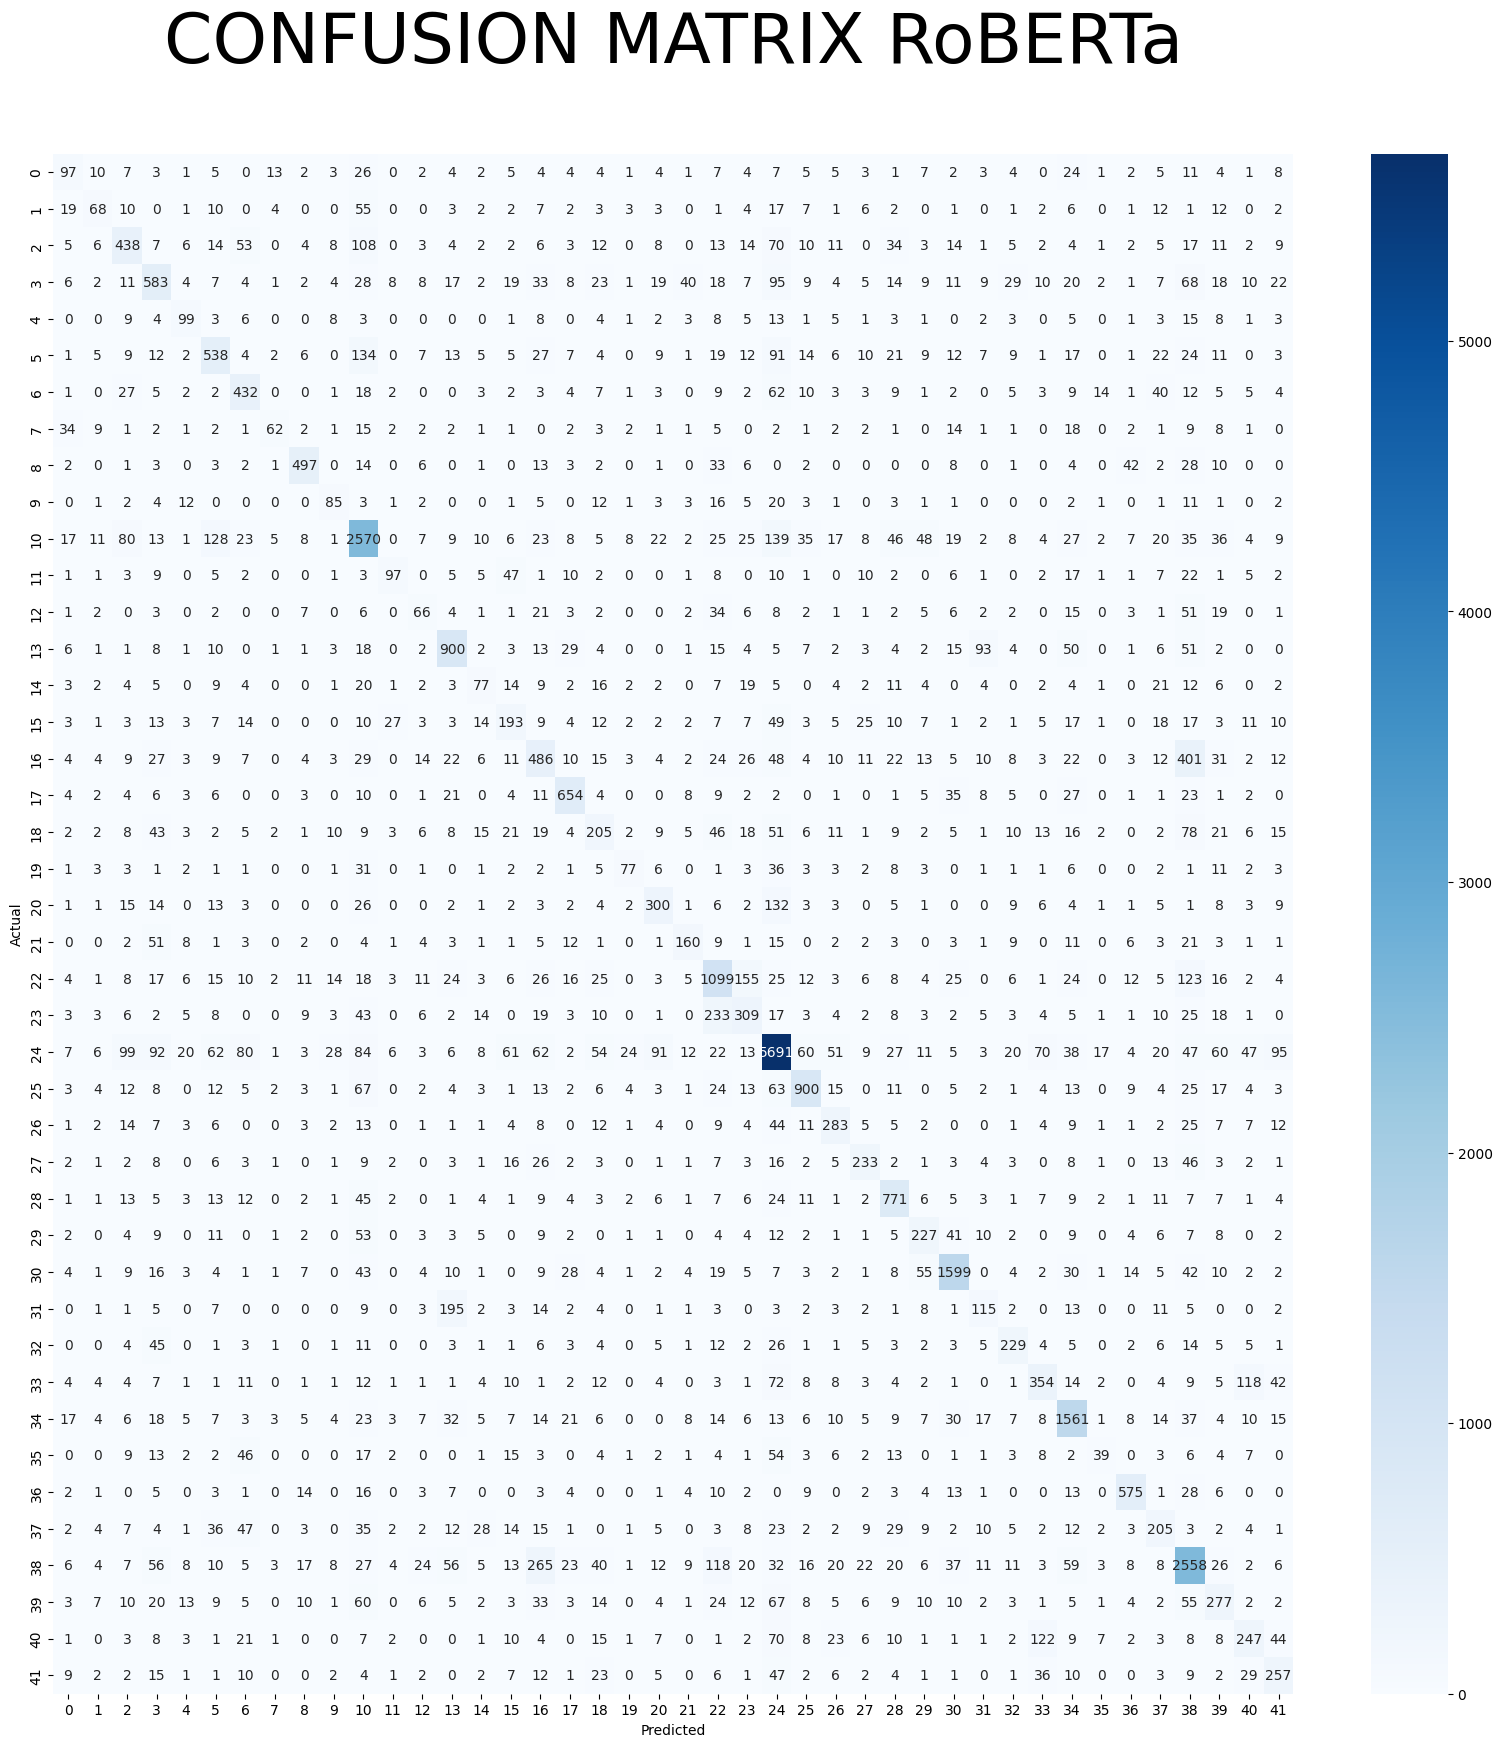

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=50)

In [ ]:
clf = MultinomialNB(force_alpha=True)
clf.fit(bow_train, train_labels)
y_pred = clf.predict(bow_test)

In [ ]:
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.4052641626497399
F1 Score (Micro) = 0.4052641626497399
F1 Score (Macro) = 0.12992589872971602


In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                precision    recall  f1-score   support

          ARTS       0.00      0.00      0.00       302
ARTS & CULTURE       0.00      0.00      0.00       268
  BLACK VOICES       0.90      0.01      0.02       917
      BUSINESS       0.89      0.05      0.10      1198
       COLLEGE       0.00      0.00      0.00       229
        COMEDY       0.91      0.02      0.04      1080
         CRIME       0.83      0.08      0.15       712
CULTURE & ARTS       1.00      0.03      0.05       215
       DIVORCE       0.98      0.08      0.14       685
     EDUCATION       0.00      0.00      0.00       203
 ENTERTAINMENT       0.56      0.71      0.63      3473
   ENVIRONMENT       1.00      0.02      0.04       289
         FIFTY       0.00      0.00      0.00       280
  FOOD & DRINK       0.75      0.23      0.36      1268
     GOOD NEWS       0.00      0.00      0.00       280
         GREEN       0.60      0.01      0.01       524
HEALTHY LIVING       0.88      0.01      0.01  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

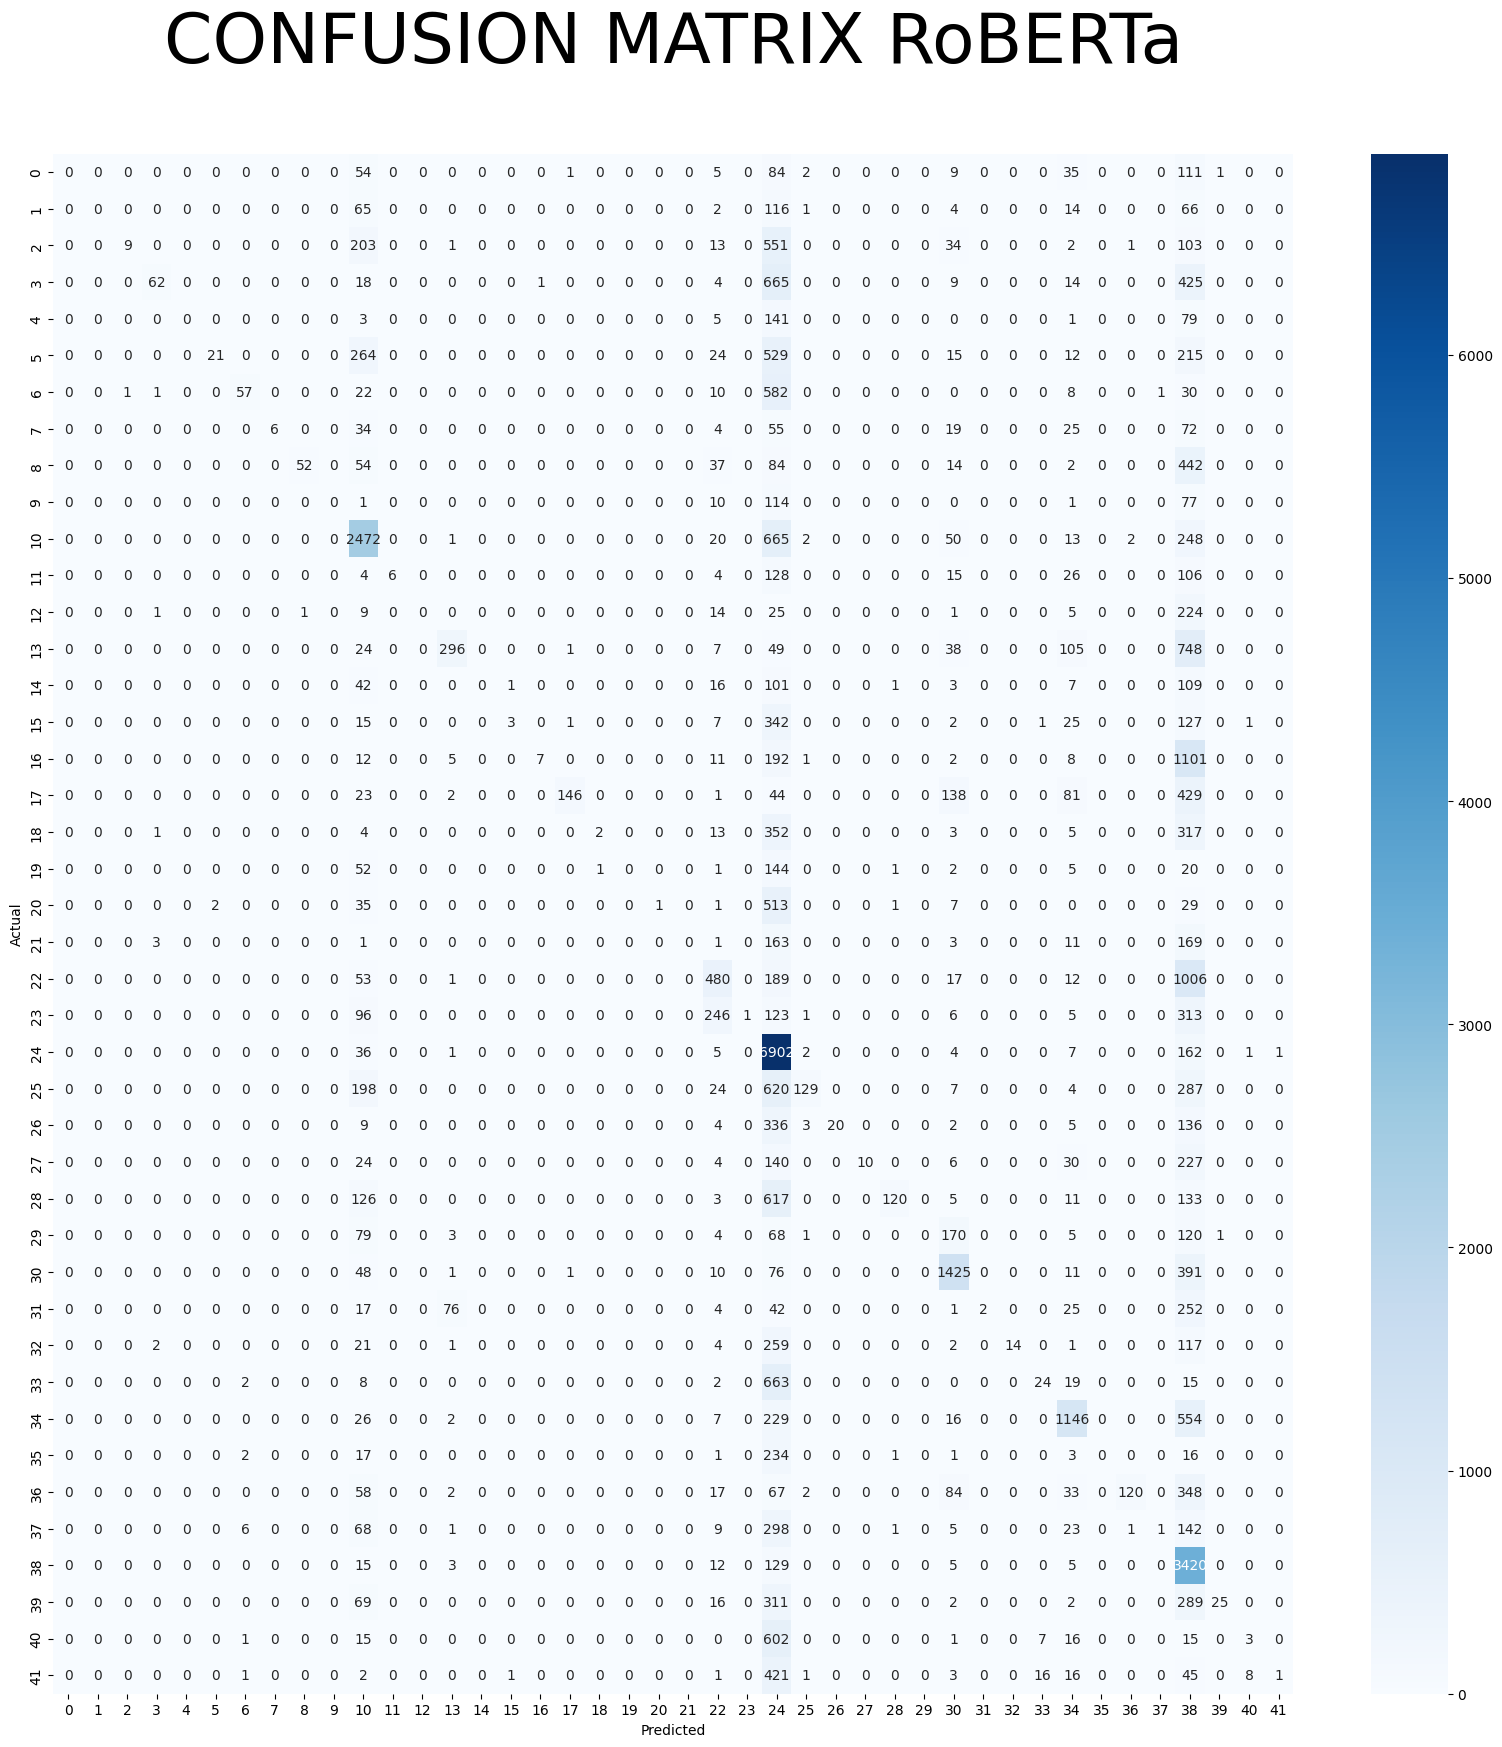

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=50)

2. Токенизация + лемматизация + стоп-слова

In [ ]:
clf = LinearSVC(C=0.04, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(bow_train, train_labels)
y_pred = clf.predict(bow_test)

In [ ]:
# с = 0.04
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
f1_score_weighted = metrics.f1_score(test_labels, y_pred, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.6190760272991934
F1 Score (Micro) = 0.6190760272991934
F1 Score (Macro) = 0.5055269248818275
F1 Score (Weighted) = 0.61661462496881


In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS

                precision    recall  f1-score   support

          ARTS       0.33      0.33      0.33       302
ARTS & CULTURE       0.29      0.26      0.27       268
  BLACK VOICES       0.51      0.50      0.50       917
      BUSINESS       0.52      0.50      0.51      1198
       COLLEGE       0.42      0.53      0.47       229
        COMEDY       0.57      0.49      0.53      1080
         CRIME       0.48      0.65      0.55       712
CULTURE & ARTS       0.62      0.28      0.39       215
       DIVORCE       0.77      0.74      0.76       685
     EDUCATION       0.40      0.51      0.45       203
 ENTERTAINMENT       0.71      0.69      0.70      3473
   ENVIRONMENT       0.53      0.32      0.40       289
         FIFTY       0.32      0.24      0.28       280
  FOOD & DRINK       0.62      0.72      0.67      1268
     GOOD NEWS       0.29      0.31      0.30       280
         GREEN       0.39      0.43      0.41       524
HEALTHY LIVING    

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

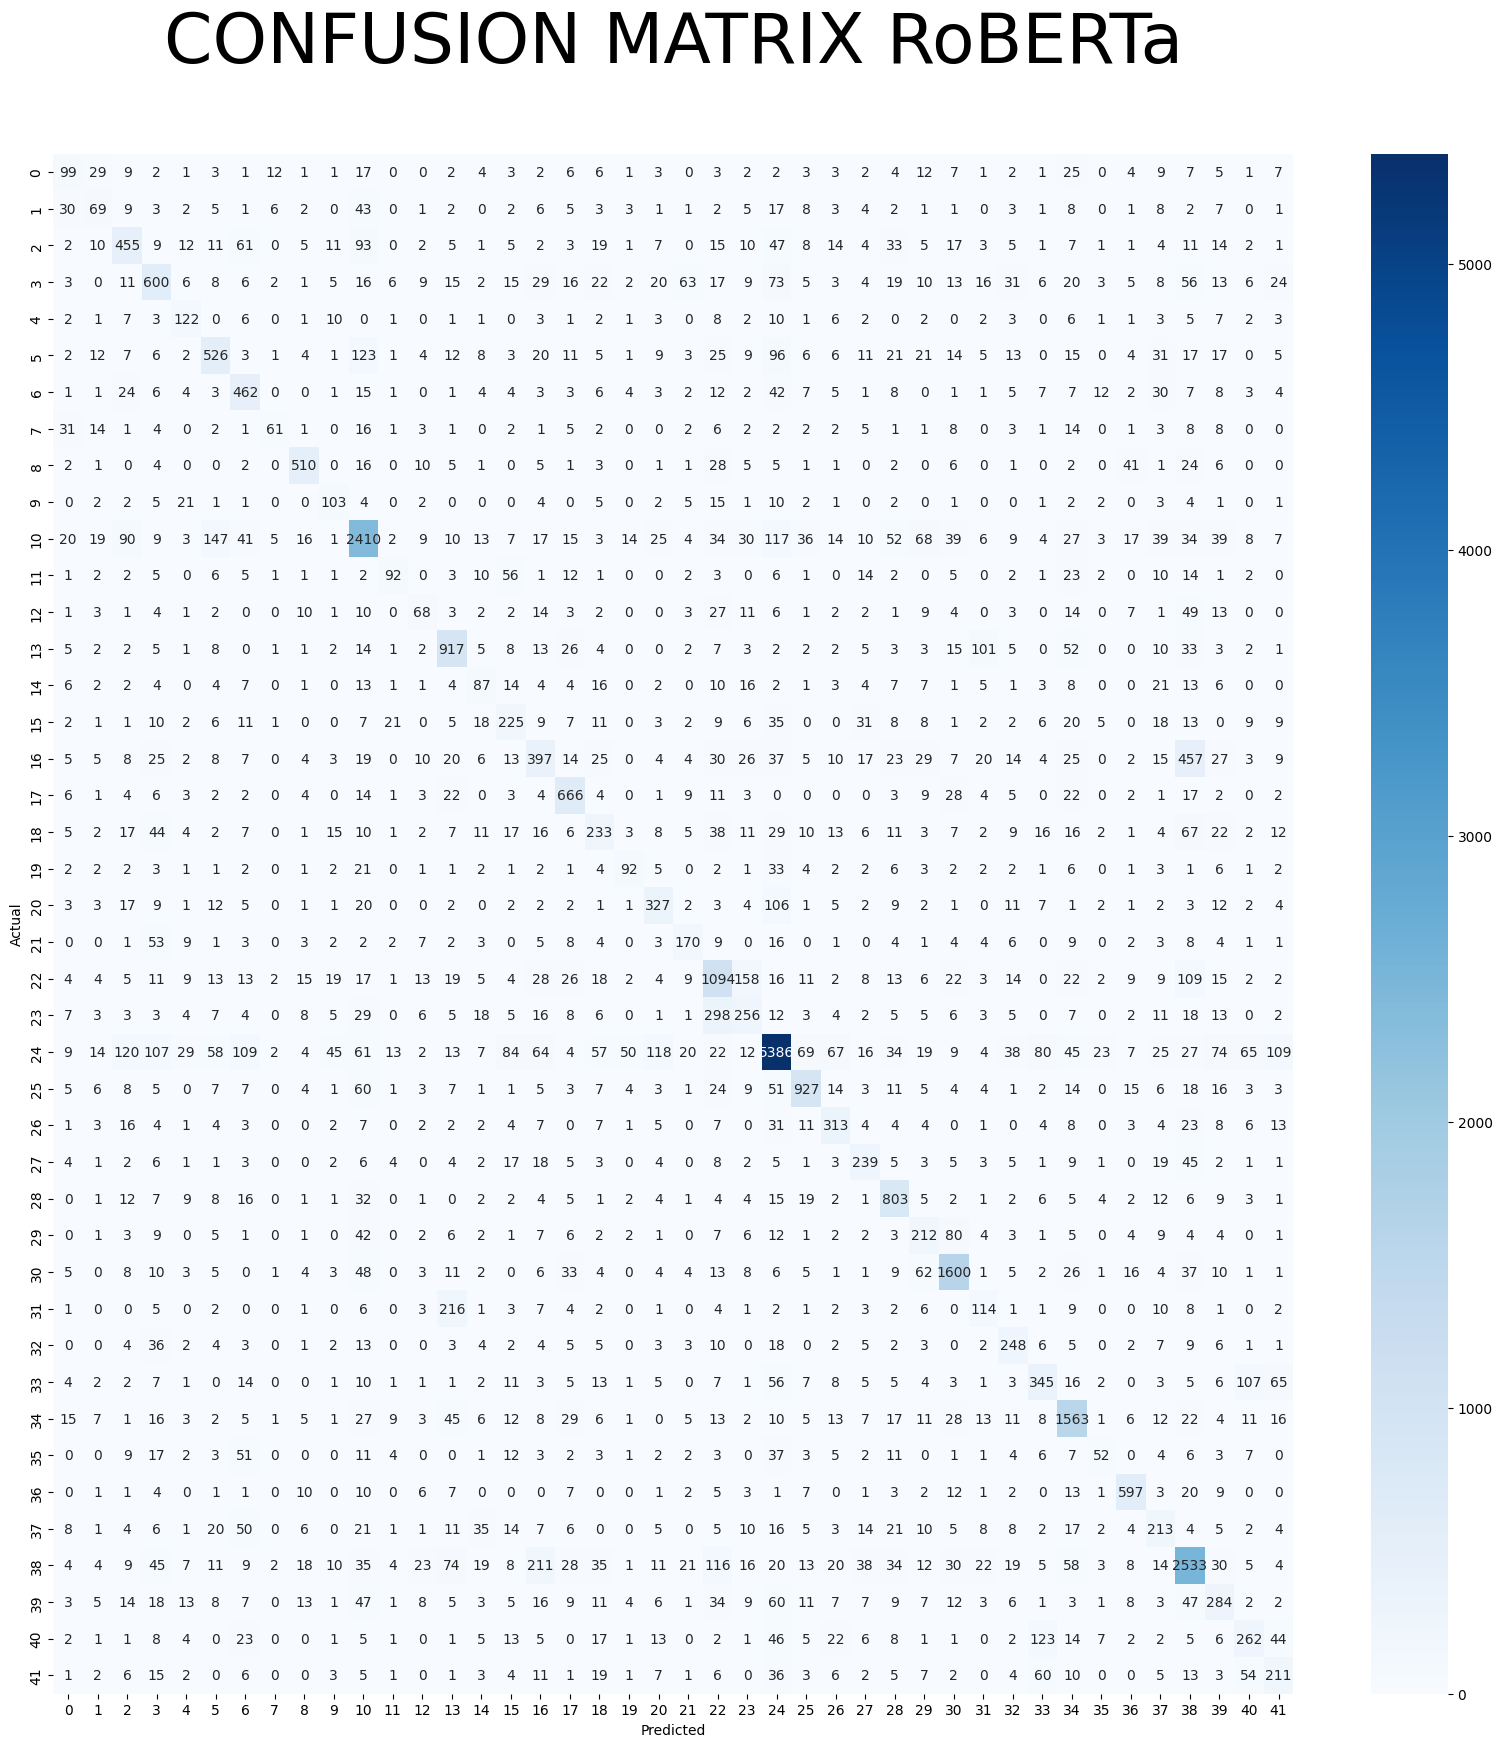

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=50)

3. Токенизация + стоп-слова + стемминг

In [ ]:
clf = LinearSVC(C=0.04, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(bow_train, train_labels)
y_pred = clf.predict(bow_test)

In [ ]:
# с = 0.04
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
f1_score_weighted = metrics.f1_score(test_labels, y_pred, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.6190760272991934
F1 Score (Micro) = 0.6190760272991934
F1 Score (Macro) = 0.5055269248818275
F1 Score (Weighted) = 0.61661462496881


In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS

                precision    recall  f1-score   support

          ARTS       0.33      0.33      0.33       302
ARTS & CULTURE       0.29      0.26      0.27       268
  BLACK VOICES       0.51      0.50      0.50       917
      BUSINESS       0.52      0.50      0.51      1198
       COLLEGE       0.42      0.53      0.47       229
        COMEDY       0.57      0.49      0.53      1080
         CRIME       0.48      0.65      0.55       712
CULTURE & ARTS       0.62      0.28      0.39       215
       DIVORCE       0.77      0.74      0.76       685
     EDUCATION       0.40      0.51      0.45       203
 ENTERTAINMENT       0.71      0.69      0.70      3473
   ENVIRONMENT       0.53      0.32      0.40       289
         FIFTY       0.32      0.24      0.28       280
  FOOD & DRINK       0.62      0.72      0.67      1268
     GOOD NEWS       0.29      0.31      0.30       280
         GREEN       0.39      0.43      0.41       524
HEALTHY LIVING    

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

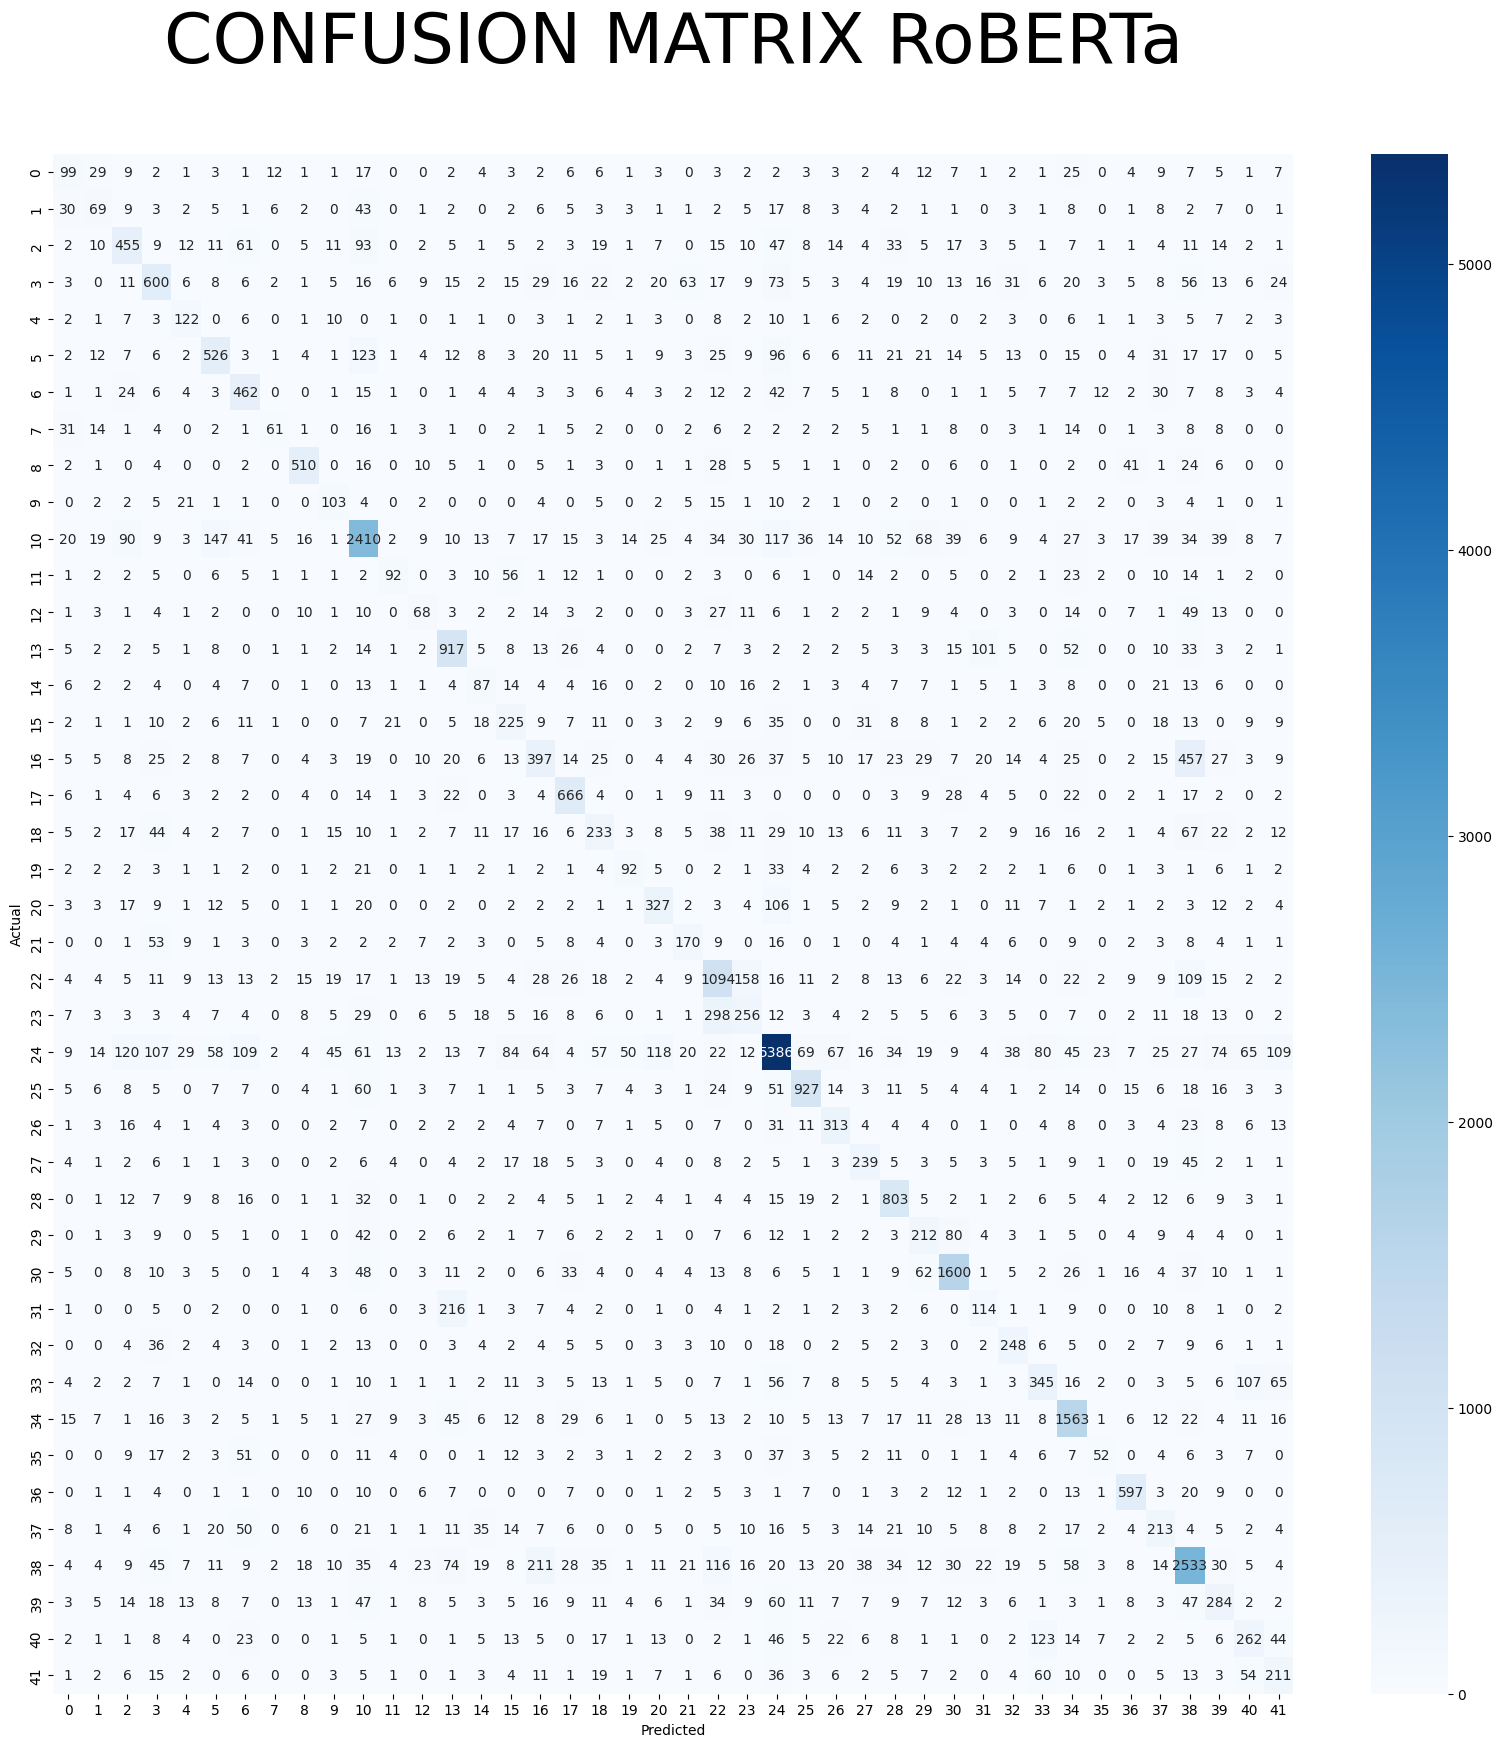

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=50)

4. Токенизация + стемминг

In [ ]:
clf = LinearSVC(C=0.05, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(bow_train, train_labels)
y_pred = clf.predict(bow_test)

In [ ]:
# с = 0.05
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
f1_score_weighted = metrics.f1_score(test_labels, y_pred, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.6152340953562736
F1 Score (Micro) = 0.6152340953562736
F1 Score (Macro) = 0.4988800582335535
F1 Score (Weighted) = 0.6127284710723025


In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS

                precision    recall  f1-score   support

          ARTS       0.29      0.28      0.28       302
ARTS & CULTURE       0.33      0.25      0.28       268
  BLACK VOICES       0.49      0.48      0.49       917
      BUSINESS       0.49      0.49      0.49      1198
       COLLEGE       0.42      0.45      0.44       229
        COMEDY       0.54      0.50      0.52      1080
         CRIME       0.50      0.62      0.56       712
CULTURE & ARTS       0.51      0.27      0.35       215
       DIVORCE       0.77      0.74      0.76       685
     EDUCATION       0.39      0.45      0.42       203
 ENTERTAINMENT       0.70      0.70      0.70      3473
   ENVIRONMENT       0.52      0.30      0.38       289
         FIFTY       0.29      0.24      0.27       280
  FOOD & DRINK       0.64      0.71      0.67      1268
     GOOD NEWS       0.29      0.30      0.29       280
         GREEN       0.36      0.40      0.38       524
HEALTHY LIVING    

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

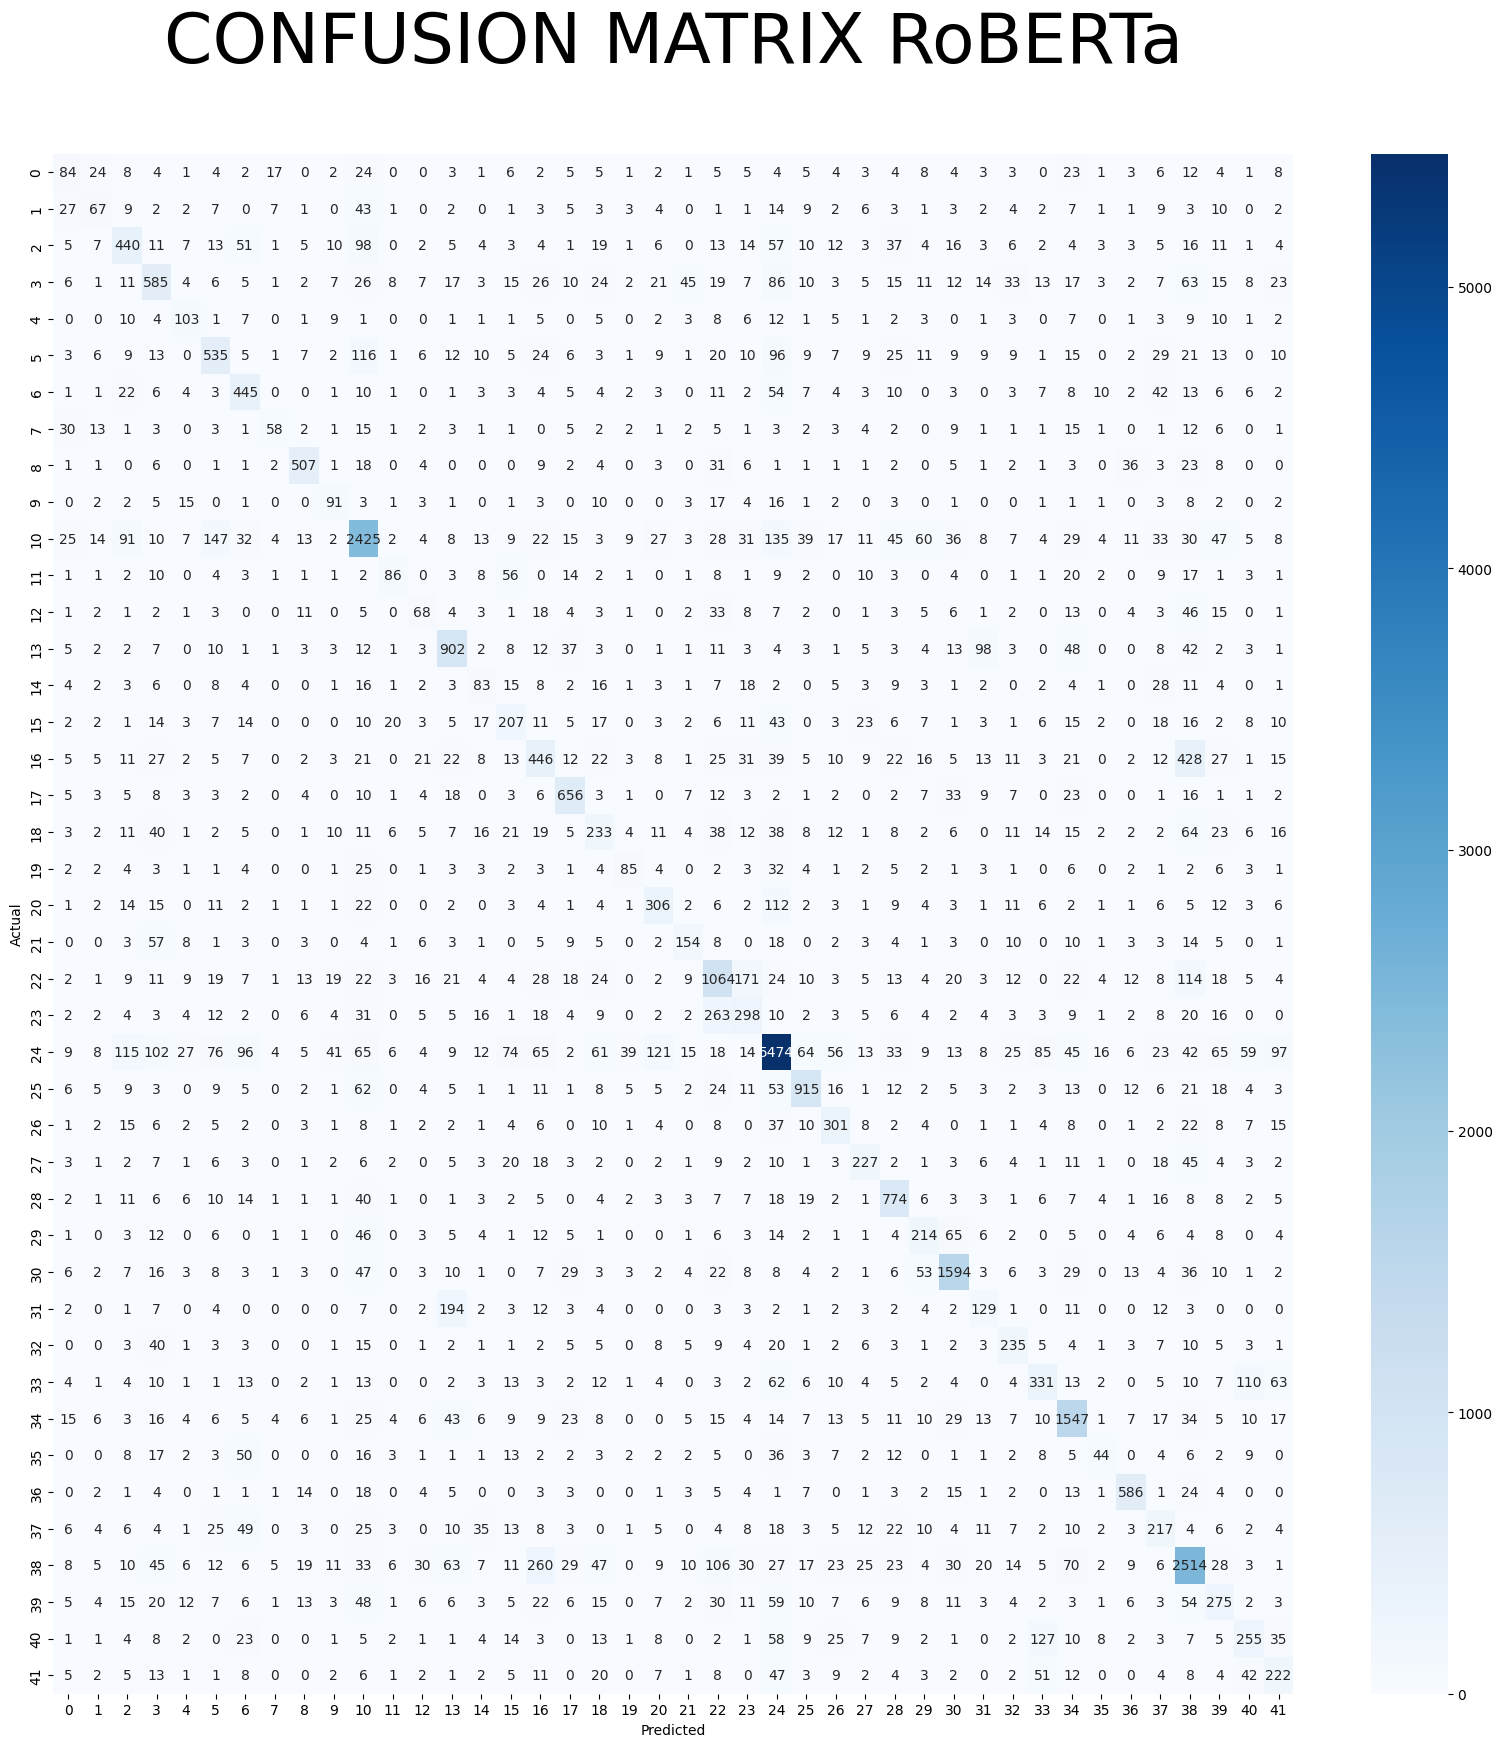

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=50)

5. Токенизация + лемматизация

In [ ]:
clf = LinearSVC(C=0.03, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(bow_train, train_labels)
y_pred = clf.predict(bow_test)

In [ ]:
# с = 0.03
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
f1_score_weighted = metrics.f1_score(test_labels, y_pred, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.6155920393261108
F1 Score (Micro) = 0.6155920393261108
F1 Score (Macro) = 0.5024518876513313
F1 Score (Weighted) = 0.6147482277217045


In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS

                precision    recall  f1-score   support

          ARTS       0.28      0.28      0.28       302
ARTS & CULTURE       0.31      0.26      0.28       268
  BLACK VOICES       0.50      0.49      0.50       917
      BUSINESS       0.50      0.49      0.49      1198
       COLLEGE       0.41      0.48      0.44       229
        COMEDY       0.55      0.50      0.53      1080
         CRIME       0.50      0.65      0.56       712
CULTURE & ARTS       0.50      0.29      0.37       215
       DIVORCE       0.76      0.75      0.76       685
     EDUCATION       0.37      0.47      0.42       203
 ENTERTAINMENT       0.72      0.68      0.70      3473
   ENVIRONMENT       0.51      0.31      0.39       289
         FIFTY       0.28      0.25      0.26       280
  FOOD & DRINK       0.63      0.72      0.67      1268
     GOOD NEWS       0.28      0.32      0.30       280
         GREEN       0.37      0.41      0.39       524
HEALTHY LIVING    

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

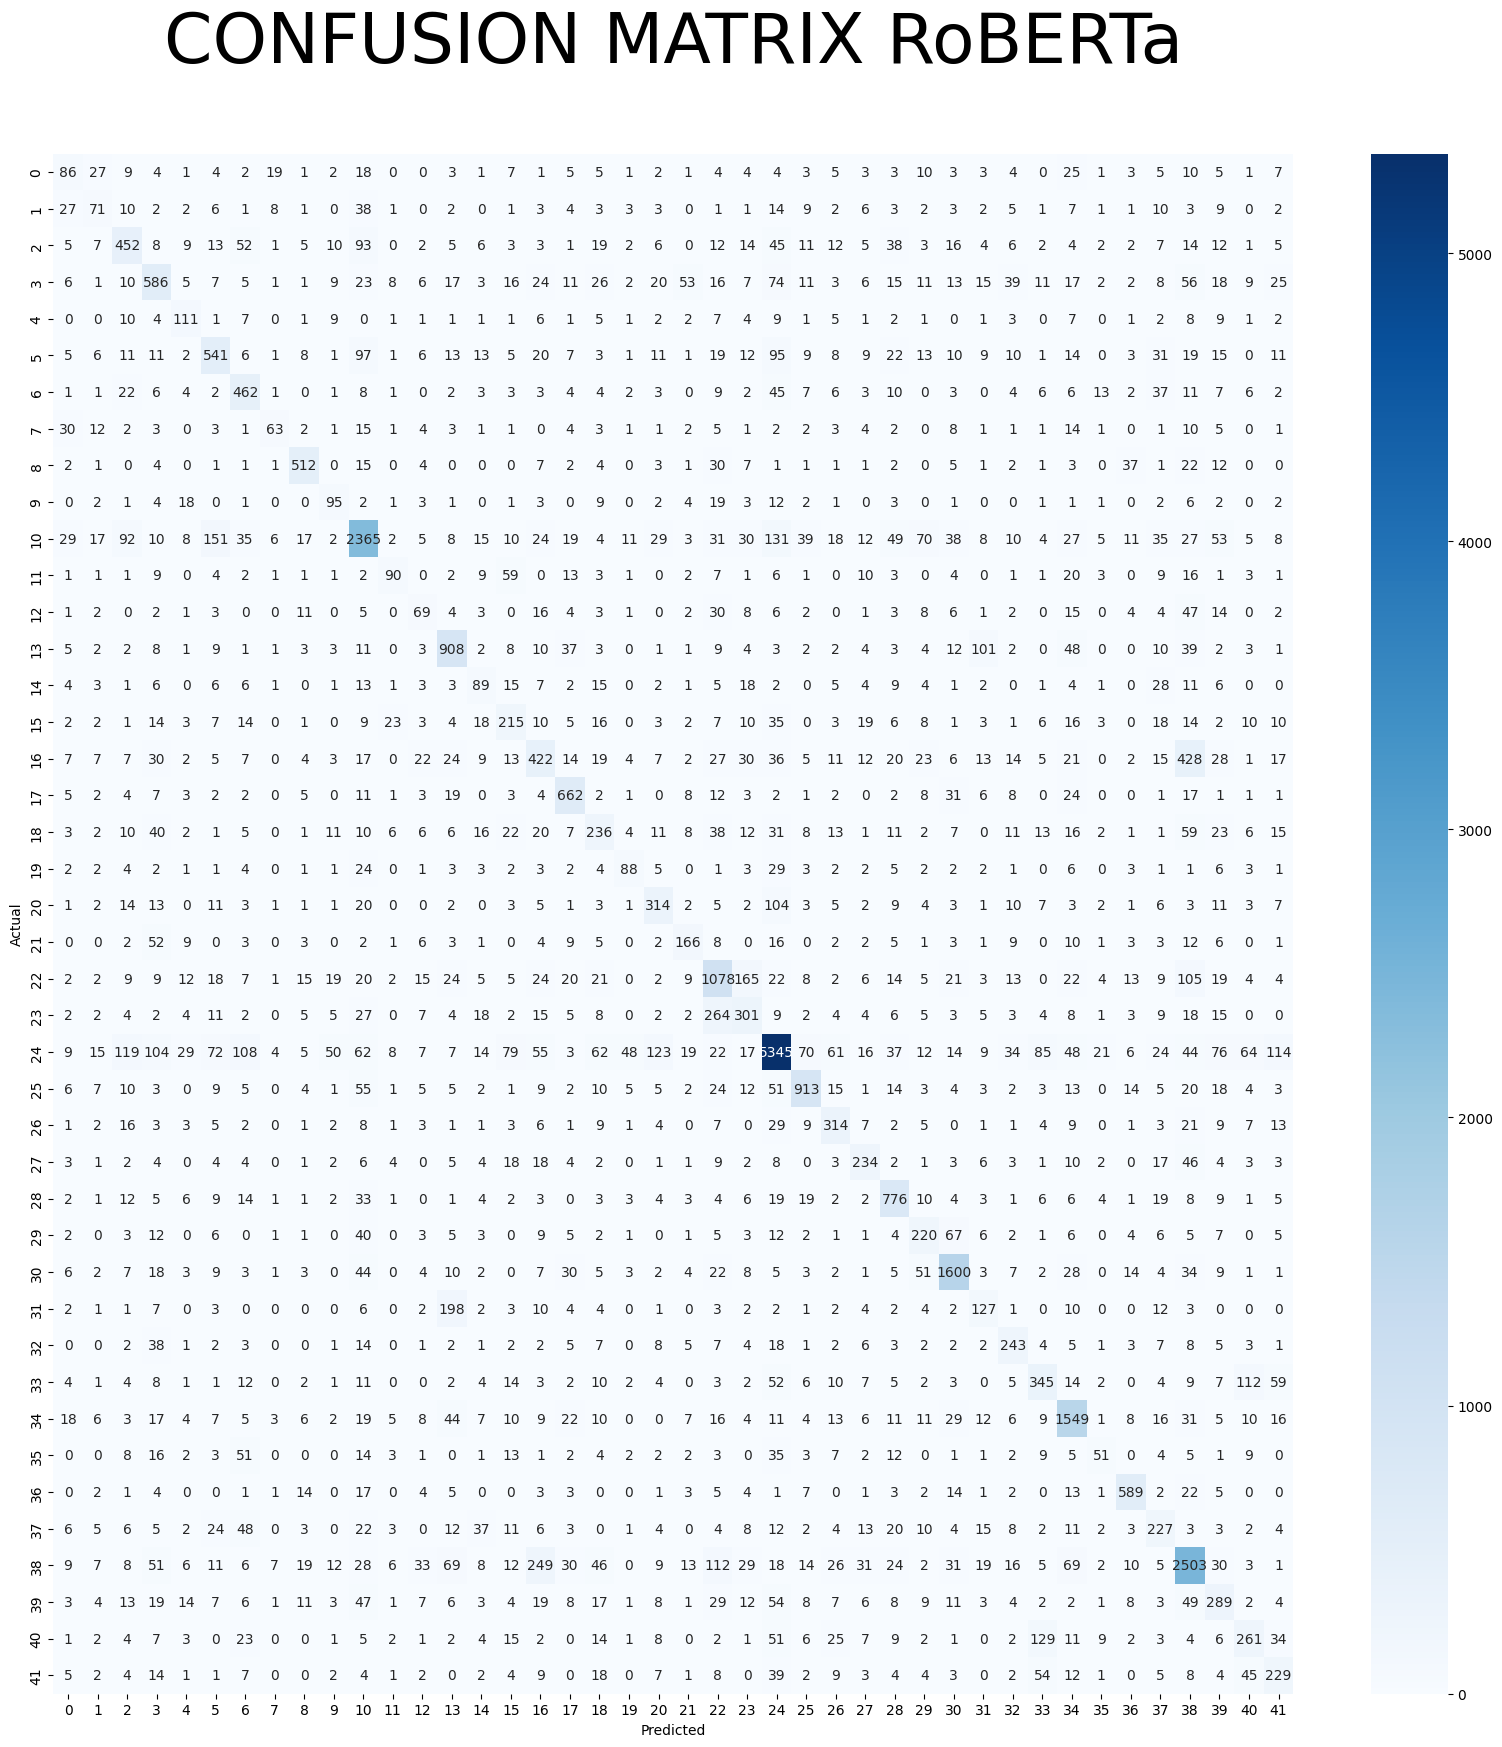

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=50)

6. Токенизация + удаление стоп-слов

In [ ]:
clf = LinearSVC(C=0.04, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(bow_train, train_labels)
y_pred = clf.predict(bow_test)

In [ ]:
# с = 0.04
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
f1_score_weighted = metrics.f1_score(test_labels, y_pred, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.6190760272991934
F1 Score (Micro) = 0.6190760272991934
F1 Score (Macro) = 0.5055269248818275
F1 Score (Weighted) = 0.61661462496881


In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS

                precision    recall  f1-score   support

          ARTS       0.33      0.33      0.33       302
ARTS & CULTURE       0.29      0.26      0.27       268
  BLACK VOICES       0.51      0.50      0.50       917
      BUSINESS       0.52      0.50      0.51      1198
       COLLEGE       0.42      0.53      0.47       229
        COMEDY       0.57      0.49      0.53      1080
         CRIME       0.48      0.65      0.55       712
CULTURE & ARTS       0.62      0.28      0.39       215
       DIVORCE       0.77      0.74      0.76       685
     EDUCATION       0.40      0.51      0.45       203
 ENTERTAINMENT       0.71      0.69      0.70      3473
   ENVIRONMENT       0.53      0.32      0.40       289
         FIFTY       0.32      0.24      0.28       280
  FOOD & DRINK       0.62      0.72      0.67      1268
     GOOD NEWS       0.29      0.31      0.30       280
         GREEN       0.39      0.43      0.41       524
HEALTHY LIVING    

Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

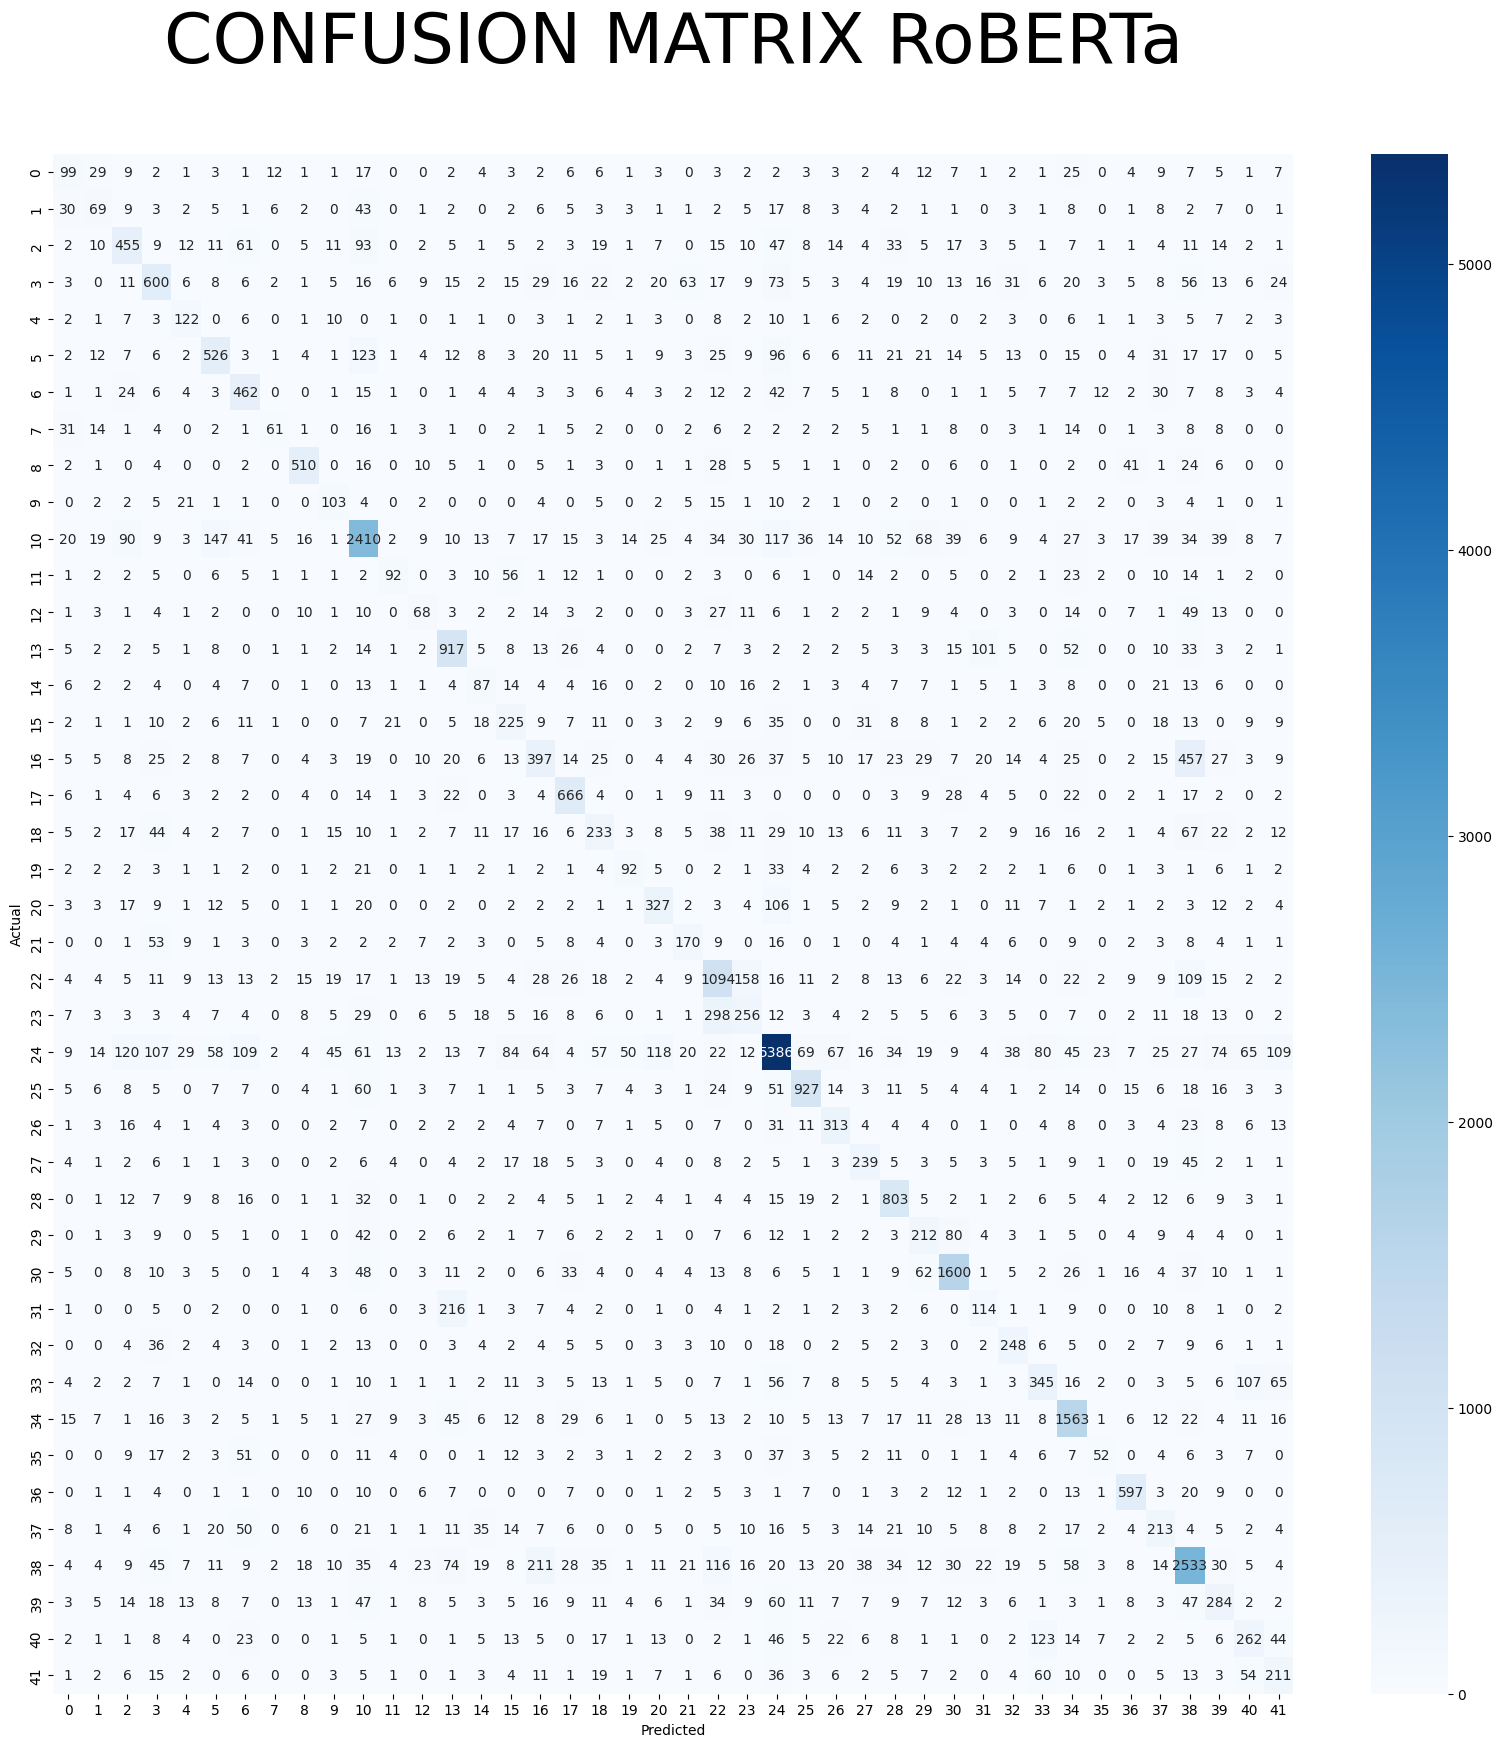

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=50)